In [ ]:
#ahmadreza baqerzadeh homaee

In [ ]:
import torch as tc 
from torch import nn,optim 
from torchmetrics import Accuracy 
from torch.utils.data import DataLoader,TensorDataset 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm 
import csv
from torch.utils.data import random_split

In [ ]:
!uncompress /content/shuttle.trn.Z

gzip: /content/shuttle.trn.Z: No such file or directory


In [ ]:
def read_file(file):
  with open(file, 'rb') as fh:
      decompressed_data = fh.read()
  list_data = decompressed_data.decode('utf-8').splitlines()
  row=[]
  for i in list_data:
    col=[]
    for j in i.split():
        col.append(float(j))
    row.append(col)
  pd.DataFrame(row).to_csv('train.csv')

read_file('shuttle.trn')
train=pd.read_csv('train.csv')
test=pd.read_csv('/content/shuttledata_test.csv')

In [ ]:
col=test.columns.values
change=[]
for i in col:
  change.append(float(i))

xtest=tc.cat((tc.FloatTensor(change).unsqueeze(dim=0),tc.FloatTensor(test.values)),dim=0)

In [ ]:
train.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
x=train.drop('9',axis=1)
y=train['9']-1

In [ ]:
xtrain,xvalid,ytrain,yvalid=train_test_split(x,y,train_size=0.7,random_state=42)

In [ ]:
xtrain=tc.FloatTensor(xtrain.values)
ytrain=tc.LongTensor(ytrain.values)
xvalid=tc.FloatTensor(xvalid.values)
yvalid=tc.LongTensor(yvalid.values)

In [ ]:
mean=xtrain.mean(dim=0)
std=xtrain.std(dim=0)

In [ ]:
xtrain=(xtrain-mean)/std 
xvalid=(xvalid-mean)/std 
xtest=(xtest-mean)/std

In [ ]:
train_dataset=TensorDataset(xtrain,ytrain)
valid_dataset=TensorDataset(xvalid,yvalid)

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=256,shuffle=False)

In [ ]:
device='cuda' if tc.cuda.is_available() else 'cpu'

In [ ]:
model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7))

In [ ]:
model=model.to(device)

In [ ]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model,train_loader,loss_func,optimizer,epoch):
  model.train()
  train_loss=AverageMeter()
  train_acc=Accuracy(task='multiclass',num_classes=7).to(device)
  with tqdm(train_loader,unit='batch') as tepoch:
    for x,y in tepoch:
        if epoch is not None:
          tepoch.set_description(f'Epoch{epoch}')
        x=x.to(device)
        y=y.to(device)
        yp=model(x)
        loss=loss_func(yp.squeeze(),y)
        train_loss.update(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_acc(yp,y.int())
        tepoch.set_postfix(loss=train_loss.avg,
                      accuracy=100*train_acc.compute().item())


  return model,train_loss.avg,train_acc.compute().item()

def validation(model,valid_loader,loss_func):

  valid_loss=AverageMeter()
  valid_acc=Accuracy(task='multiclass',num_classes=7).to(device)

  for j,(x,y) in enumerate(valid_loader):
    x=x.to(device)
    y=y.to(device)
    yp=model(x)
    loss=loss_func(yp.squeeze(),y)
    valid_loss.update(loss.item())
    valid_acc(yp.squeeze(),y)

  print(f'valid loss={valid_loss.avg:.4},accuracy={valid_acc.compute():.4}')
  print()

  return valid_loss.avg,valid_acc.compute().item()

In [ ]:
xbatch,ybatch=next(iter(train_loader))
yp=model(xbatch)
loss_func(yp,ybatch)
  

tensor(1.9709, grad_fn=<NllLossBackward0>)

In [ ]:
mini_batch,_=random_split(train_dataset,(100,len(train_dataset)-100))
mini_loader=DataLoader(mini_batch,batch_size=20,shuffle=True)

In [ ]:
for i in range(10):
  model,_,_=train_one_epoch(model,mini_loader,loss_func,optimizer,i)


Epoch9: 100%|██████████| 5/5 [00:00<00:00, 134.49batch/s, accuracy=89, loss=0.301]


In [ ]:
for lr in [0.1,0.01,0.001,0.0001]:
  model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7)).to(device)
  optimizer=optim.SGD(model.parameters(),lr=lr)
  print(f'LR={lr}')
  model,train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,1)

LR=0.1


Epoch1: 100%|██████████| 238/238 [00:02<00:00, 102.68batch/s, accuracy=90.1, loss=0.35]


LR=0.01


Epoch1: 100%|██████████| 238/238 [00:02<00:00, 105.57batch/s, accuracy=78.3, loss=1.13]


LR=0.001


Epoch1: 100%|██████████| 238/238 [00:02<00:00, 105.24batch/s, accuracy=0.378, loss=1.86]


LR=0.0001


Epoch1: 100%|██████████| 238/238 [00:02<00:00, 109.26batch/s, accuracy=0.0197, loss=1.96]


In [ ]:
lr_n=[0.1,0.15,0.2,0.25]
wd_n=[0,1e-4,1e-5,1e-6,1e-7]
result=[]
for lr in lr_n:
  lr_result=[]
  for wd in wd_n:
    model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7)).to(device)
    optimizer=optim.SGD(model.parameters(),lr=lr)
    N=5
    print(f'LR={lr},weight_decay={wd}')

    for i in range(N):

      model,train_loss,_=train_one_epoch(model,train_loader,loss_func,optimizer,i)

      if i==0:
        e1=train_loss
      if i==N-1:
        e2=train_loss

    lr_result.append(f'{e1:.4}-{e2:.4}={e1-e2:.4}')
    print()
  result.append(lr_result)

LR=0.1,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 94.13batch/s, accuracy=99.4, loss=0.0462]



LR=0.1,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 101.55batch/s, accuracy=99.4, loss=0.0431]



LR=0.1,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 105.19batch/s, accuracy=99.3, loss=0.0435]



LR=0.1,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 106.16batch/s, accuracy=99.4, loss=0.0449]



LR=0.1,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 107.97batch/s, accuracy=99.4, loss=0.0408]



LR=0.15,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 106.06batch/s, accuracy=99.4, loss=0.0337]



LR=0.15,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 108.14batch/s, accuracy=99.5, loss=0.0318]



LR=0.15,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 106.28batch/s, accuracy=99.4, loss=0.0345]



LR=0.15,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 108.86batch/s, accuracy=99.5, loss=0.0311]



LR=0.15,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 109.59batch/s, accuracy=99.5, loss=0.0357]



LR=0.2,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 106.40batch/s, accuracy=99.4, loss=0.0309]



LR=0.2,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 97.67batch/s, accuracy=99.4, loss=0.0303]



LR=0.2,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 103.06batch/s, accuracy=99.5, loss=0.0326]



LR=0.2,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 103.20batch/s, accuracy=99.4, loss=0.0284]



LR=0.2,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 103.22batch/s, accuracy=99.5, loss=0.0299]



LR=0.25,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 97.55batch/s, accuracy=99.4, loss=0.0284]



LR=0.25,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 98.20batch/s, accuracy=99.4, loss=0.0269]



LR=0.25,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 104.27batch/s, accuracy=99.5, loss=0.0261]



LR=0.25,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 105.97batch/s, accuracy=99.4, loss=0.0271]



LR=0.25,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:02<00:00, 101.81batch/s, accuracy=99.5, loss=0.025]

In [ ]:
pd.DataFrame(result,index=lr_n,columns=wd_n)

,0.000000e+00,1.000000e-04,1.000000e-05,1.000000e-06,1.000000e-07
0.10,0.4025-0.04622=0.3563,0.3837-0.0431=0.3406,0.3338-0.04354=0.2903,0.3625-0.04495=0.3175,0.4809-0.0408=0.4401
0.15,0.2822-0.03371=0.2485,0.2501-0.03179=0.2183,0.2833-0.03452=0.2488,0.2803-0.03108=0.2492,0.3053-0.03568=0.2696
0.20,0.2168-0.03087=0.1859,0.2252-0.03032=0.1948,0.2556-0.03264=0.223,0.234-0.02835=0.2056,0.2476-0.02986=0.2177
0.25,0.2134-0.02838=0.185,0.2074-0.02695=0.1805,0.2007-0.02607=0.1746,0.204-0.02711=0.1769,0.2316-0.02501=0.2066


In [ ]:
model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7),nn.Softmax())
optimizer=optim.SGD(model.parameters(),lr=0.1,weight_decay=1e-7)

In [ ]:
model=model.to(device)

In [ ]:
N=25
acc_train_hist,loss_train_hist=[],[]
acc_valid_hist,loss_valid_hist=[],[]

for i in range(N):

  model,train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,i)
  valid_loss,valid_acc=validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

Epoch0:   0%|          | 0/238 [00:00<?, ?batch/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Epoch0: 100%|██████████| 238/238 [00:02<00:00, 107.96batch/s, accuracy=73, loss=1.56]


valid loss=1.361,accuracy=0.7858



Epoch1: 100%|██████████| 238/238 [00:02<00:00, 102.59batch/s, accuracy=78.3, loss=1.36]


valid loss=1.347,accuracy=0.7865



Epoch2: 100%|██████████| 238/238 [00:02<00:00, 108.90batch/s, accuracy=84.9, loss=1.33]


valid loss=1.301,accuracy=0.8689



Epoch3: 100%|██████████| 238/238 [00:02<00:00, 102.78batch/s, accuracy=89.4, loss=1.28]


valid loss=1.257,accuracy=0.922



Epoch4: 100%|██████████| 238/238 [00:02<00:00, 104.54batch/s, accuracy=92.4, loss=1.25]


valid loss=1.246,accuracy=0.9244



Epoch5: 100%|██████████| 238/238 [00:02<00:00, 109.03batch/s, accuracy=92.6, loss=1.24]


valid loss=1.241,accuracy=0.9281



Epoch6: 100%|██████████| 238/238 [00:02<00:00, 103.08batch/s, accuracy=92.7, loss=1.24]


valid loss=1.239,accuracy=0.9297



Epoch7: 100%|██████████| 238/238 [00:02<00:00, 100.58batch/s, accuracy=92.9, loss=1.24]


valid loss=1.236,accuracy=0.9332



Epoch8: 100%|██████████| 238/238 [00:02<00:00, 104.51batch/s, accuracy=93.2, loss=1.24]


valid loss=1.233,accuracy=0.9376



Epoch9: 100%|██████████| 238/238 [00:02<00:00, 104.59batch/s, accuracy=93.5, loss=1.23]


valid loss=1.23,accuracy=0.9389



Epoch10: 100%|██████████| 238/238 [00:02<00:00, 108.08batch/s, accuracy=93.7, loss=1.23]


valid loss=1.229,accuracy=0.9402



Epoch11: 100%|██████████| 238/238 [00:02<00:00, 108.11batch/s, accuracy=93.8, loss=1.23]


valid loss=1.228,accuracy=0.9395



Epoch12: 100%|██████████| 238/238 [00:02<00:00, 105.32batch/s, accuracy=93.8, loss=1.23]


valid loss=1.227,accuracy=0.9406



Epoch13: 100%|██████████| 238/238 [00:02<00:00, 106.92batch/s, accuracy=93.8, loss=1.23]


valid loss=1.227,accuracy=0.9403



Epoch14: 100%|██████████| 238/238 [00:02<00:00, 107.12batch/s, accuracy=93.8, loss=1.23]


valid loss=1.227,accuracy=0.9407



Epoch15: 100%|██████████| 238/238 [00:02<00:00, 103.34batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch16: 100%|██████████| 238/238 [00:02<00:00, 106.03batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch17: 100%|██████████| 238/238 [00:02<00:00, 104.22batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch18: 100%|██████████| 238/238 [00:02<00:00, 107.25batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch19: 100%|██████████| 238/238 [00:02<00:00, 104.95batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch20: 100%|██████████| 238/238 [00:02<00:00, 105.92batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch21: 100%|██████████| 238/238 [00:02<00:00, 105.95batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch22: 100%|██████████| 238/238 [00:02<00:00, 105.58batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch23: 100%|██████████| 238/238 [00:02<00:00, 108.09batch/s, accuracy=93.8, loss=1.23]


valid loss=1.226,accuracy=0.9407



Epoch24: 100%|██████████| 238/238 [00:02<00:00, 104.57batch/s, accuracy=93.8, loss=1.23]


valid loss=1.225,accuracy=0.9407



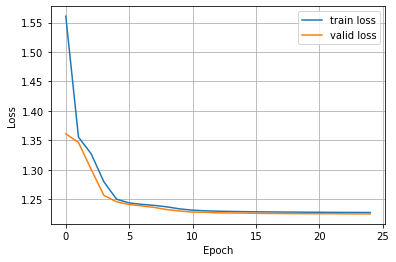

In [ ]:
plt.plot(range(N),loss_train_hist,label='train loss')
plt.plot(range(N),loss_valid_hist,label='valid loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#good fit

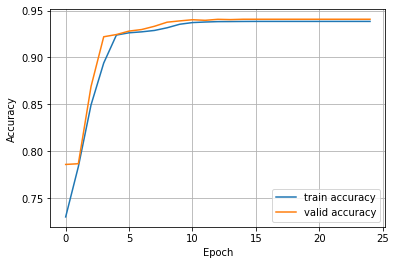

In [ ]:
plt.plot(range(N),acc_train_hist,label='train accuracy')
plt.plot(range(N),acc_valid_hist,label='valid accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
tc.save(model,'model.pth')

In [ ]:
ypred=model(xtest.to(device)).cpu()

In [ ]:
ypred_save=[]
for i in ypred:
  b=max(i)
  for j in range(len(i)):
    if i[j]==b:
      ypred_save.append(j)

In [ ]:
df_prediction=pd.DataFrame(ypred_save,columns=['pred'])+1

In [ ]:
df_prediction.to_csv('prediction.csv')

In [ ]:
model=nn.Sequential(nn.Linear(xtrain.shape[1],1024),
                    nn.ReLU(),nn.Linear(1024,512),
                    nn.ReLU(),nn.Linear(512,512),
                    nn.ReLU(),nn.Linear(512,7),
                    )
optimizer=optim.SGD(model.parameters(),lr=0.1,weight_decay=1e-7)

In [ ]:
model=model.to(device)

In [ ]:
N=25
acc_train_hist,loss_train_hist=[],[]
acc_valid_hist,loss_valid_hist=[],[]

for i in range(N):

  model,train_loss,train_acc=train_one_epoch(model,mini_loader,loss_func,optimizer,i)
  valid_loss,valid_acc=validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

Epoch0: 100%|██████████| 5/5 [00:00<00:00, 75.51batch/s, accuracy=66, loss=1.53]


valid loss=0.8753,accuracy=0.7858



Epoch1: 100%|██████████| 5/5 [00:00<00:00, 75.75batch/s, accuracy=83, loss=0.576]


valid loss=0.4992,accuracy=0.8262



Epoch2: 100%|██████████| 5/5 [00:00<00:00, 62.66batch/s, accuracy=89, loss=0.371]


valid loss=0.388,accuracy=0.8407



Epoch3: 100%|██████████| 5/5 [00:00<00:00, 68.93batch/s, accuracy=89, loss=0.266]


valid loss=0.3369,accuracy=0.8408



Epoch4: 100%|██████████| 5/5 [00:00<00:00, 70.03batch/s, accuracy=91, loss=0.21]


valid loss=0.2722,accuracy=0.9134



Epoch5: 100%|██████████| 5/5 [00:00<00:00, 64.20batch/s, accuracy=94, loss=0.165]


valid loss=0.2406,accuracy=0.9639



Epoch6: 100%|██████████| 5/5 [00:00<00:00, 70.31batch/s, accuracy=98, loss=0.134]


valid loss=0.2152,accuracy=0.9679



Epoch7: 100%|██████████| 5/5 [00:00<00:00, 68.11batch/s, accuracy=97, loss=0.106]


valid loss=0.2181,accuracy=0.962



Epoch8: 100%|██████████| 5/5 [00:00<00:00, 70.83batch/s, accuracy=97, loss=0.0963]


valid loss=0.1921,accuracy=0.9687



Epoch9: 100%|██████████| 5/5 [00:00<00:00, 70.14batch/s, accuracy=100, loss=0.0728]


valid loss=0.1878,accuracy=0.9671



Epoch10: 100%|██████████| 5/5 [00:00<00:00, 67.92batch/s, accuracy=100, loss=0.0615]


valid loss=0.1877,accuracy=0.9649



Epoch11: 100%|██████████| 5/5 [00:00<00:00, 66.25batch/s, accuracy=100, loss=0.0526]


valid loss=0.1846,accuracy=0.9632



Epoch12: 100%|██████████| 5/5 [00:00<00:00, 68.97batch/s, accuracy=100, loss=0.0415]


valid loss=0.1825,accuracy=0.9679



Epoch13: 100%|██████████| 5/5 [00:00<00:00, 61.36batch/s, accuracy=100, loss=0.0396]


valid loss=0.1912,accuracy=0.9598



Epoch14: 100%|██████████| 5/5 [00:00<00:00, 64.65batch/s, accuracy=100, loss=0.0315]


valid loss=0.1848,accuracy=0.9653



Epoch15: 100%|██████████| 5/5 [00:00<00:00, 61.95batch/s, accuracy=100, loss=0.0268]


valid loss=0.1924,accuracy=0.9615



Epoch16: 100%|██████████| 5/5 [00:00<00:00, 68.01batch/s, accuracy=100, loss=0.0271]


valid loss=0.2008,accuracy=0.9582



Epoch17: 100%|██████████| 5/5 [00:00<00:00, 68.59batch/s, accuracy=100, loss=0.022]


valid loss=0.191,accuracy=0.9651



Epoch18: 100%|██████████| 5/5 [00:00<00:00, 62.71batch/s, accuracy=100, loss=0.0209]


valid loss=0.1942,accuracy=0.9641



Epoch19: 100%|██████████| 5/5 [00:00<00:00, 65.57batch/s, accuracy=100, loss=0.018]


valid loss=0.1967,accuracy=0.9641



Epoch20: 100%|██████████| 5/5 [00:00<00:00, 69.26batch/s, accuracy=100, loss=0.016]


valid loss=0.2095,accuracy=0.9608



Epoch21: 100%|██████████| 5/5 [00:00<00:00, 62.43batch/s, accuracy=100, loss=0.0145]


valid loss=0.2081,accuracy=0.9611



Epoch22: 100%|██████████| 5/5 [00:00<00:00, 70.84batch/s, accuracy=100, loss=0.0137]


valid loss=0.2064,accuracy=0.9638



Epoch23: 100%|██████████| 5/5 [00:00<00:00, 72.70batch/s, accuracy=100, loss=0.0127]


valid loss=0.2125,accuracy=0.9612



Epoch24: 100%|██████████| 5/5 [00:00<00:00, 71.49batch/s, accuracy=100, loss=0.0118]


valid loss=0.2136,accuracy=0.9629



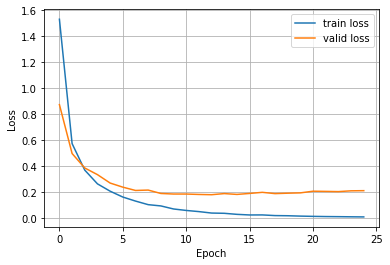

In [ ]:
plt.plot(range(N),loss_train_hist,label='train loss')
plt.plot(range(N),loss_valid_hist,label='valid loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model=nn.Sequential(nn.Linear(xtrain.shape[1],1024),
                    nn.Dropout(0.1),
                    nn.ReLU(),nn.Linear(1024,512),
                    nn.Dropout(0.3),
                    nn.ReLU(),nn.Linear(512,512),
                    nn.Dropout(0.5),
                    nn.ReLU(),nn.Linear(512,7),
                    )
optimizer=optim.SGD(model.parameters(),lr=0.1,weight_decay=1e-7)
optimizer=optim.SGD(model.parameters(),lr=0.1,weight_decay=1e-7)

In [ ]:
model=model.to(device)

In [ ]:
N=25
acc_train_hist,loss_train_hist=[],[]
acc_valid_hist,loss_valid_hist=[],[]

for i in range(N):

  model,train_loss,train_acc=train_one_epoch(model,mini_loader,loss_func,optimizer,i)
  valid_loss,valid_acc=validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

Epoch0: 100%|██████████| 5/5 [00:00<00:00, 35.61batch/s, accuracy=65, loss=1.63]


valid loss=1.017,accuracy=0.7858



Epoch1: 100%|██████████| 5/5 [00:00<00:00, 49.91batch/s, accuracy=83, loss=0.692]


valid loss=0.5821,accuracy=0.7862



Epoch2: 100%|██████████| 5/5 [00:00<00:00, 62.37batch/s, accuracy=84, loss=0.437]


valid loss=0.4299,accuracy=0.8397



Epoch3: 100%|██████████| 5/5 [00:00<00:00, 75.58batch/s, accuracy=89, loss=0.322]


valid loss=0.3591,accuracy=0.8492



Epoch4: 100%|██████████| 5/5 [00:00<00:00, 70.68batch/s, accuracy=92, loss=0.226]


valid loss=0.3068,accuracy=0.8681



Epoch5: 100%|██████████| 5/5 [00:00<00:00, 62.91batch/s, accuracy=94, loss=0.178]


valid loss=0.2649,accuracy=0.9296



Epoch6: 100%|██████████| 5/5 [00:00<00:00, 65.38batch/s, accuracy=93, loss=0.191]


valid loss=0.2593,accuracy=0.9182



Epoch7: 100%|██████████| 5/5 [00:00<00:00, 72.24batch/s, accuracy=93, loss=0.147]


valid loss=0.2456,accuracy=0.9494



Epoch8: 100%|██████████| 5/5 [00:00<00:00, 63.41batch/s, accuracy=97, loss=0.125]


valid loss=0.2373,accuracy=0.9363



Epoch9: 100%|██████████| 5/5 [00:00<00:00, 65.78batch/s, accuracy=95, loss=0.127]


valid loss=0.2232,accuracy=0.9602



Epoch10: 100%|██████████| 5/5 [00:00<00:00, 71.65batch/s, accuracy=97, loss=0.093]


valid loss=0.205,accuracy=0.9641



Epoch11: 100%|██████████| 5/5 [00:00<00:00, 67.46batch/s, accuracy=100, loss=0.0666]


valid loss=0.2044,accuracy=0.9641



Epoch12: 100%|██████████| 5/5 [00:00<00:00, 68.86batch/s, accuracy=100, loss=0.0626]


valid loss=0.2062,accuracy=0.9613



Epoch13: 100%|██████████| 5/5 [00:00<00:00, 66.55batch/s, accuracy=99, loss=0.0606]


valid loss=0.2176,accuracy=0.9553



Epoch14: 100%|██████████| 5/5 [00:00<00:00, 70.11batch/s, accuracy=99, loss=0.0766]


valid loss=0.2015,accuracy=0.9664



Epoch15: 100%|██████████| 5/5 [00:00<00:00, 69.58batch/s, accuracy=100, loss=0.0372]


valid loss=0.2066,accuracy=0.9591



Epoch16: 100%|██████████| 5/5 [00:00<00:00, 60.77batch/s, accuracy=100, loss=0.0393]


valid loss=0.1958,accuracy=0.9651



Epoch17: 100%|██████████| 5/5 [00:00<00:00, 65.21batch/s, accuracy=100, loss=0.0338]


valid loss=0.219,accuracy=0.9586



Epoch18: 100%|██████████| 5/5 [00:00<00:00, 58.95batch/s, accuracy=100, loss=0.032]


valid loss=0.2225,accuracy=0.9602



Epoch19: 100%|██████████| 5/5 [00:00<00:00, 63.77batch/s, accuracy=100, loss=0.0275]


valid loss=0.2141,accuracy=0.9635



Epoch20: 100%|██████████| 5/5 [00:00<00:00, 69.85batch/s, accuracy=100, loss=0.0266]


valid loss=0.2114,accuracy=0.9633



Epoch21: 100%|██████████| 5/5 [00:00<00:00, 71.27batch/s, accuracy=100, loss=0.0193]


valid loss=0.2437,accuracy=0.9572



Epoch22: 100%|██████████| 5/5 [00:00<00:00, 54.55batch/s, accuracy=100, loss=0.0196]


valid loss=0.239,accuracy=0.9581



Epoch23: 100%|██████████| 5/5 [00:00<00:00, 66.39batch/s, accuracy=100, loss=0.019]


valid loss=0.2374,accuracy=0.9609



Epoch24: 100%|██████████| 5/5 [00:00<00:00, 58.50batch/s, accuracy=100, loss=0.0208]


valid loss=0.214,accuracy=0.9661



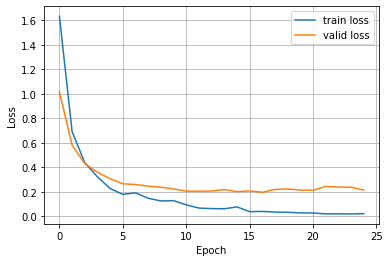

In [ ]:
plt.plot(range(N),loss_train_hist,label='train loss')
plt.plot(range(N),loss_valid_hist,label='valid loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()